In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from gempy import coKriging
from gempy import GridClass
import pandas as pd


C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [2]:
def create_sgs_dataframe(geomodel, grid, formation):
    """
    Method to create a new pandas dataframe combining Input Data for SGS CoKriging
    Except variogram data!
    Args:
        geomodel (numpy.ndarray): lithological block model created with gempy
        grid (gempy.data_management.GridClass): Grid created for geologic model
        formation (int): Number of formation to perform CoKriging on
         - property_data (???): data of all properties relevant for CoKriging - (not yet)
    Returns
        pandas.dataframe: Combined dataframe with all relevant data
    """
    import pandas as pd
    
    # convert lith block values to int, need to do this properly - uncorrect as of now
    lith_block_int = np.round(lith_block)
    
    # create the dataframe and populate with data
    d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0]}
    df_cokr = pd.DataFrame(data=d)
    
    df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
    df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
    del df_sgs_grid['index'] # reset indices
    
    return df_sgs_grid

In [21]:
# only for 3 properties fix right now

def perform_sgs(property_data, sgs_grid):
    """
    Method to perform the SGS run, creating a new dataframe with the resulting grid, 
    containing the interpolated data fro the CoKriging
    Args:
        property_data (pandas.datframe): frame containing property data with corresponding X,Y,Z coordinates
        sgs_grid (pandas.dataframe): frame containing grid, meaning all X,Y,Z coordinates in domain 
    Returns:
        Result: Dataframe containg all interpolated values with corresponding coordinates       
    """
    # new dataframe for all results
    results = pd.DataFrame(columns=['X','Y','Z','prop1','prop2','prop3'])
    
    # both Input dfs should not be changed
    df_prop_calc = property_data.copy() #copy dataframe for appending results for SGS
    df_sgs_grid_calc = sgs_grid.copy() #copy of grid frame to delete data
    
    for i in range(0, len(sgs_grid)):
        
        # choose random point from df_sgs_grid_calc
        rand_pos = np.random.randint(0,len(df_sgs_grid_calc))
        random_coord = np.array([df_sgs_grid_calc.loc[rand_pos,'X'],df_sgs_grid_calc.loc[rand_pos,'Y'],df_sgs_grid_calc.loc[rand_pos,'Z']])
        #random_coord = df_sgs_grid_calc[rand_pos][['X','Y','Z']] - this does not work
        
        # delete point from the df sgs_grid_calc
        df_sgs_grid_calc = df_sgs_grid_calc.drop([rand_pos])
        df_sgs_grid_calc = df_sgs_grid_calc.reset_index() # reset indicies
        del df_sgs_grid_calc['index'] #reset indices
        
        # perform the CoKriging interpolation on this point
        new_interpolated_point = CoKriging(random_coord, df_prop_calc, i) 
                            
        # append result to df_prop_calc to use for further SGS
        df_prop_calc.loc[len(df_prop_calc)]=new_interpolated_point
        
        # append results to final results dataframe that will be returned
        results.loc[len(results)]=new_interpolated_point
    
    return results

In [4]:
def CoKriging(coord_to_inter, df_prop_data, t):
    """
    Method to perform Cokriging at one point based on a set of input points, considering multiple variables
    Args:
        coord_to_interpolate: X,Y,Z coordinates of point where properties should be interpolated
        property_data: dataset of property data for interpolation (including coordinates)
    Returns:
        x (np.array): Array with results of interpolation, including x,y,z coord and interpolated property data
    """
    x = np.array([coord_to_inter[0] ,coord_to_inter[1], coord_to_inter[2], t, t*2, t/3])
    #Test method for SGS Run
    return x
    

In [5]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tutorial_ch3_interfaces") # importing point-positional interface data

In [6]:
# gp.get_data(geo_data)

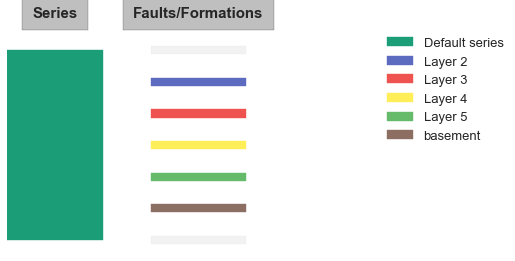

In [7]:
%matplotlib inline
gp.get_sequential_pile(geo_data)

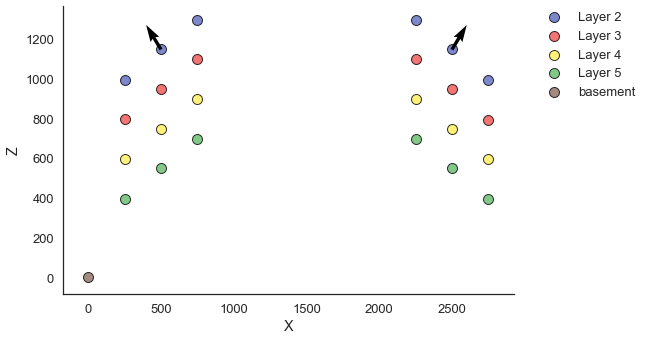

In [8]:
%matplotlib inline
gp.plotting.plot_data(geo_data, direction='y')

In [9]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')
#print(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [10]:
lith_block, fault_block = gp.compute_model(interp_data)

In [11]:
df_cokr_cut = create_sgs_dataframe(lith_block[0],geo_data.grid, formation=3)

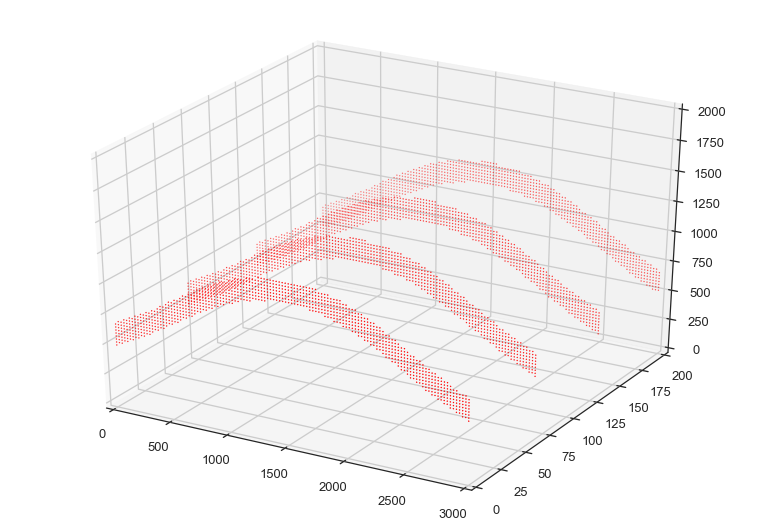

In [12]:
# visualization of grid, cut down to one lithology
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=df_cokr_cut.X,ys=df_cokr_cut.Y,zs=df_cokr_cut.Z, c=df_cokr_cut.lith, s=1, cmap='prism')

In [13]:
#section plotted in classical gempy plot_section for comparison

#%matplotlib inline
#gp.plotting.plot_section(geo_data, lith_block[0], cell_number=0,  direction='y', plot_data=False)

In [14]:
x = list([260,1450,550])
y = list([100,0,200])
z = list([550,1150,850])
prop1 = list([0.1,0.2,0.3])
prop2 = list([0.2,0.4,0.8])
prop3 = list([0.05,0.1,0.1])

In [15]:
# creating dataframe and populating it with our data
d = {'X': x, 'Y': y, 'Z': z, 'prop1': prop1, 'prop2': prop2, 'prop3': prop3}
df_prop = pd.DataFrame(data=d)

In [16]:
exp_var = gp.coKriging.compute_crossvariogram(df_prop, ("prop1","prop2","prop3"))

C:\Users\Jan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


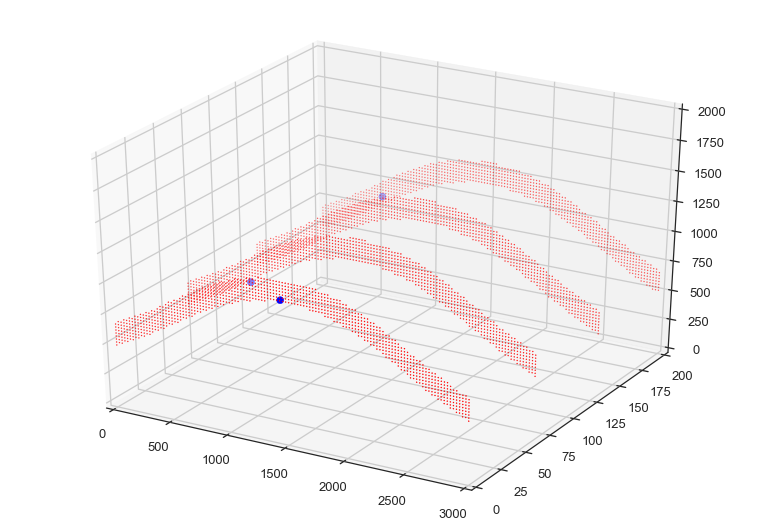

In [17]:
# visualization of grid, cut down to one lithology, as well as property Input data from dataframe
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=df_cokr_cut.X,ys=df_cokr_cut.Y,zs=df_cokr_cut.Z, c=df_cokr_cut.lith, s=1, cmap='prism')
ax.scatter3D(xs=df_prop.X,ys=df_prop.Y,zs=df_prop.Z, c='blue', s=50)

In [22]:
results = perform_sgs(df_prop, df_cokr_cut) # dauert auch jetzt ohne Rechnung recht lange

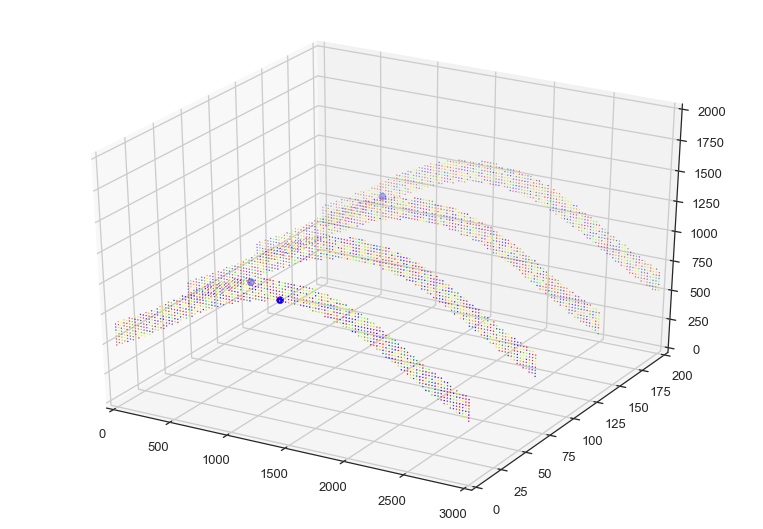

In [23]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
ax.scatter3D(xs=results.X,ys=results.Y,zs=results.Z, c=results.prop1, s=1, cmap='prism')
ax.scatter3D(xs=df_prop.X,ys=df_prop.Y,zs=df_prop.Z, c='blue', s=50)